In [3]:
blue = "#0072be"
orange = "#ff7800"
yellow = "#edb120"  
purple = "#7d2e8f"
green = "#78ac2f"
red = "#a41530"
cyan = "#4fbdef"
brown = "#8b564c"
pink = "#e377c1"
grey = "#7f7f7f"
import pandas
import os
import numpy as np
CALVADOS_COM = "$\\rm{CALVADOS_{COM}}$"
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import sys
sys.path.append('./src/BLOCKING')
sys.path.append('./src')
from main import BlockAnalysis
from matplotlib.colors import LogNorm
from scipy.optimize import least_squares
import mdtraj as md
import matplotlib.pyplot as plt
from protein_repo import *
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(suppress=True)  # Cancel scientific counting display
np.set_printoptions(threshold=np.inf)
import matplotlib as mpl
def get_predictions(cwd, dataset, cycle, validate, PRE_seq, bootstrapping=False):
    multidomain_names = list(pd.read_pickle(f"{cwd}/{dataset}/MultiDomainsRgs.pkl").index)
    allproteins = pd.read_pickle(f"{cwd}/{dataset}/allproteins.pkl")
    if validate:
        multidomain_names_test = list(pd.read_pickle(f"{cwd}/{dataset}/MultiDomainsRgs_test.pkl").index)
        multidomain_names = np.setdiff1d(multidomain_names_test, multidomain_names).tolist()
        allproteins_test = pd.read_pickle(f"{cwd}/{dataset}/allproteins_test.pkl")
        allproteins = allproteins_test.loc[np.setdiff1d(list(allproteins_test.index), list(allproteins.index))]
    allproteins = allproteins.loc[np.setdiff1d(list(allproteins.index), PRE_seq)]  # might exclude aSyn, but because aSyn has different names in both dataframe, it still can be included anyway.
    IDP_names = list(np.setdiff1d(list(allproteins.index), multidomain_names))
    cal, bt = [], []
    # bsheet_per = []

    for name in allproteins.index:
        if name in ['FP_Ash1_FP', 'FP_E1A_FP', 'FP_F1_GS16_FP', 'FP_F1_GS30_FP', 'FP_F1_GS8_FP', 'FP_F3_GS16_FP', 'FP_F3_GS30_FP',
            'FP_F3_GS8_FP', 'FP_FRQ_N_CRA_WF81AA_FP', 'FP_FRQ_N_CRA_native_FP', 'FP_FRQ_N_CRA_phos_full_FP', 'FP_FRQ_N_DIS_FP',
            'FP_FRQ_N_TET_FP', 'FP_FRQ_T_REE_FP', 'FP_FUS_FP', 'FP_PUMA_S1_FP', 'FP_PUMA_S2_FP', 'FP_PUMA_S3_FP', 'FP_PUMA_WT_FP', 'FP_p53_FP',
        'SNAP_FUS_PLDY2F_RBDR2K', 'SNAP_FUS_PLDY2F', 'SNAP_FUS', 'GFP_FUS', 'FUS_PLDY2F_RBDR2K', 'FL_FUS']:  # , 'hSUMO_hnRNPA1S', 'hnRNPA1S'
            if name in multidomain_names:
                multidomain_names.remove(name)
            else:
                IDP_names.remove(name)
        if "@" in name:
            if name in multidomain_names:
                multidomain_names.remove(name)
            else:
                IDP_names.remove(name)
    allproteins = allproteins.loc[IDP_names+multidomain_names]
    for name in allproteins.index:
        if not os.path.isfile(f"{cwd}/{dataset}/{name}/{cycle + 1}/Rg_traj.npy"):
            df = pd.read_csv(f'{cwd}/{dataset}/residues_{cycle}.csv').set_index('three')
            t = md.load_dcd(f"{cwd}/{dataset}/{name}/{cycle + 1}/{name}.dcd",
                            f"{cwd}/{dataset}/{name}/{cycle + 1}/{name}.pdb")
            residues = [res.name for res in t.top.atoms]
            masses = df.loc[residues, 'MW'].values
            masses[0] += 2
            masses[-1] += 16
            # calculate the center of mass
            cm = np.sum(t.xyz * masses[np.newaxis, :, np.newaxis], axis=1) / masses.sum()
            # calculate residue-cm distances
            si = np.linalg.norm(t.xyz - cm[:, np.newaxis, :], axis=2)
            # calculate rg
            rgarray = np.sqrt(np.sum(si ** 2 * masses, axis=1) / masses.sum())
            np.save(f"{cwd}/{dataset}/{name}/{cycle + 1}/Rg_traj.npy", rgarray)

        else:
            rgarray = np.load(f"{cwd}/{dataset}/{name}/{cycle + 1}/Rg_traj.npy")

        if bootstrapping:
            numkeep = int(len(rgarray) * 0.9)
            res = np.zeros(shape=(times, numkeep))  # (times, n_traj)
            for time in range(times):
                res[time] = np.random.choice(rgarray, size=numkeep, replace=False)
            cal_res = np.mean(res, axis=1)
        cal_value = np.mean(rgarray)

        cal.append(cal_value)
        bt.append(cal_res)
        """if name in multidomain_names:
            ssdomains = get_ssdomains(name, f"{cwd}/domains.yaml")
            len_domain = 0
            for ssdomain in ssdomains:
                len_domain += len(ssdomain)
            bsheet_per.append(np.load(f"{cwd}/relax_stride/{name}_SScount.npy", allow_pickle=True).item()["E"]/len_domain)"""

    allproteins["cal"] = cal
    allproteins["bt"] = bt
    allproteins['N'] = allproteins['fasta'].apply(lambda x: len(x))
    allproteins = allproteins.sort_values('N', ascending=False)
    allproteins.to_pickle(f"{cwd}/{dataset}/predictions.pkl")
    print(IDP_names, multidomain_names)

    return allproteins, IDP_names, multidomain_names

/storage1/fancao/miniconda/envs/CALVADOSCOM/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/storage1/fancao/miniconda/envs/CALVADOSCOM/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


['A1', 'ACTR', 'Ash1', 'CAHSD', 'CTD2', 'CoRNID', 'ColNT', 'FhuA', 'GHRICD', 'Hst5', 'Hst52', 'K10', 'K23', 'K25', 'K27', 'K32', 'K44', 'M10FP7RP12D', 'M10R', 'M10RP10K', 'M12FP12Y', 'M12FP12YM10R', 'M3RP3K', 'M4D', 'M6R', 'M6RP6K', 'M8FP4Y', 'M9FP3Y', 'M9FP6Y', 'P12D', 'P12E', 'P2R', 'P4D', 'P7FM7Y', 'P7KP12D', 'P7KP12Db', 'P7R', 'P8D', 'PNt', 'PNtS1', 'PNtS4', 'PNtS5', 'PNtS6', 'RNaseA', 'SH4UD', 'Sic1', 'aSyn140', 'hNL3cyt', 'p15PAF', 'p532070', 'tau35'] ['GS48', 'GS32', 'GS24', 'GS16', 'GS8', 'GS0', 'hSUMO_hnRNPA1S', 'TIA1', 'Gal3', 'Ubq4', 'Ubq3', 'Ubq2', 'THB_C2', 'hnRNPA1S']
              expRg       cal  expRgErr
A1            2.760  2.725796     0.020
ACTR          2.630  2.388045     0.100
Ash1          2.900  2.674909     0.050
CAHSD         4.840  4.693623     0.200
CTD2          2.614  2.341828     0.050
CoRNID        4.700  4.690201     0.200
ColNT         2.800  2.577552     0.033
FhuA          3.340  3.391705     0.100
GHRICD        6.000  5.923570     0.500
Hst5       

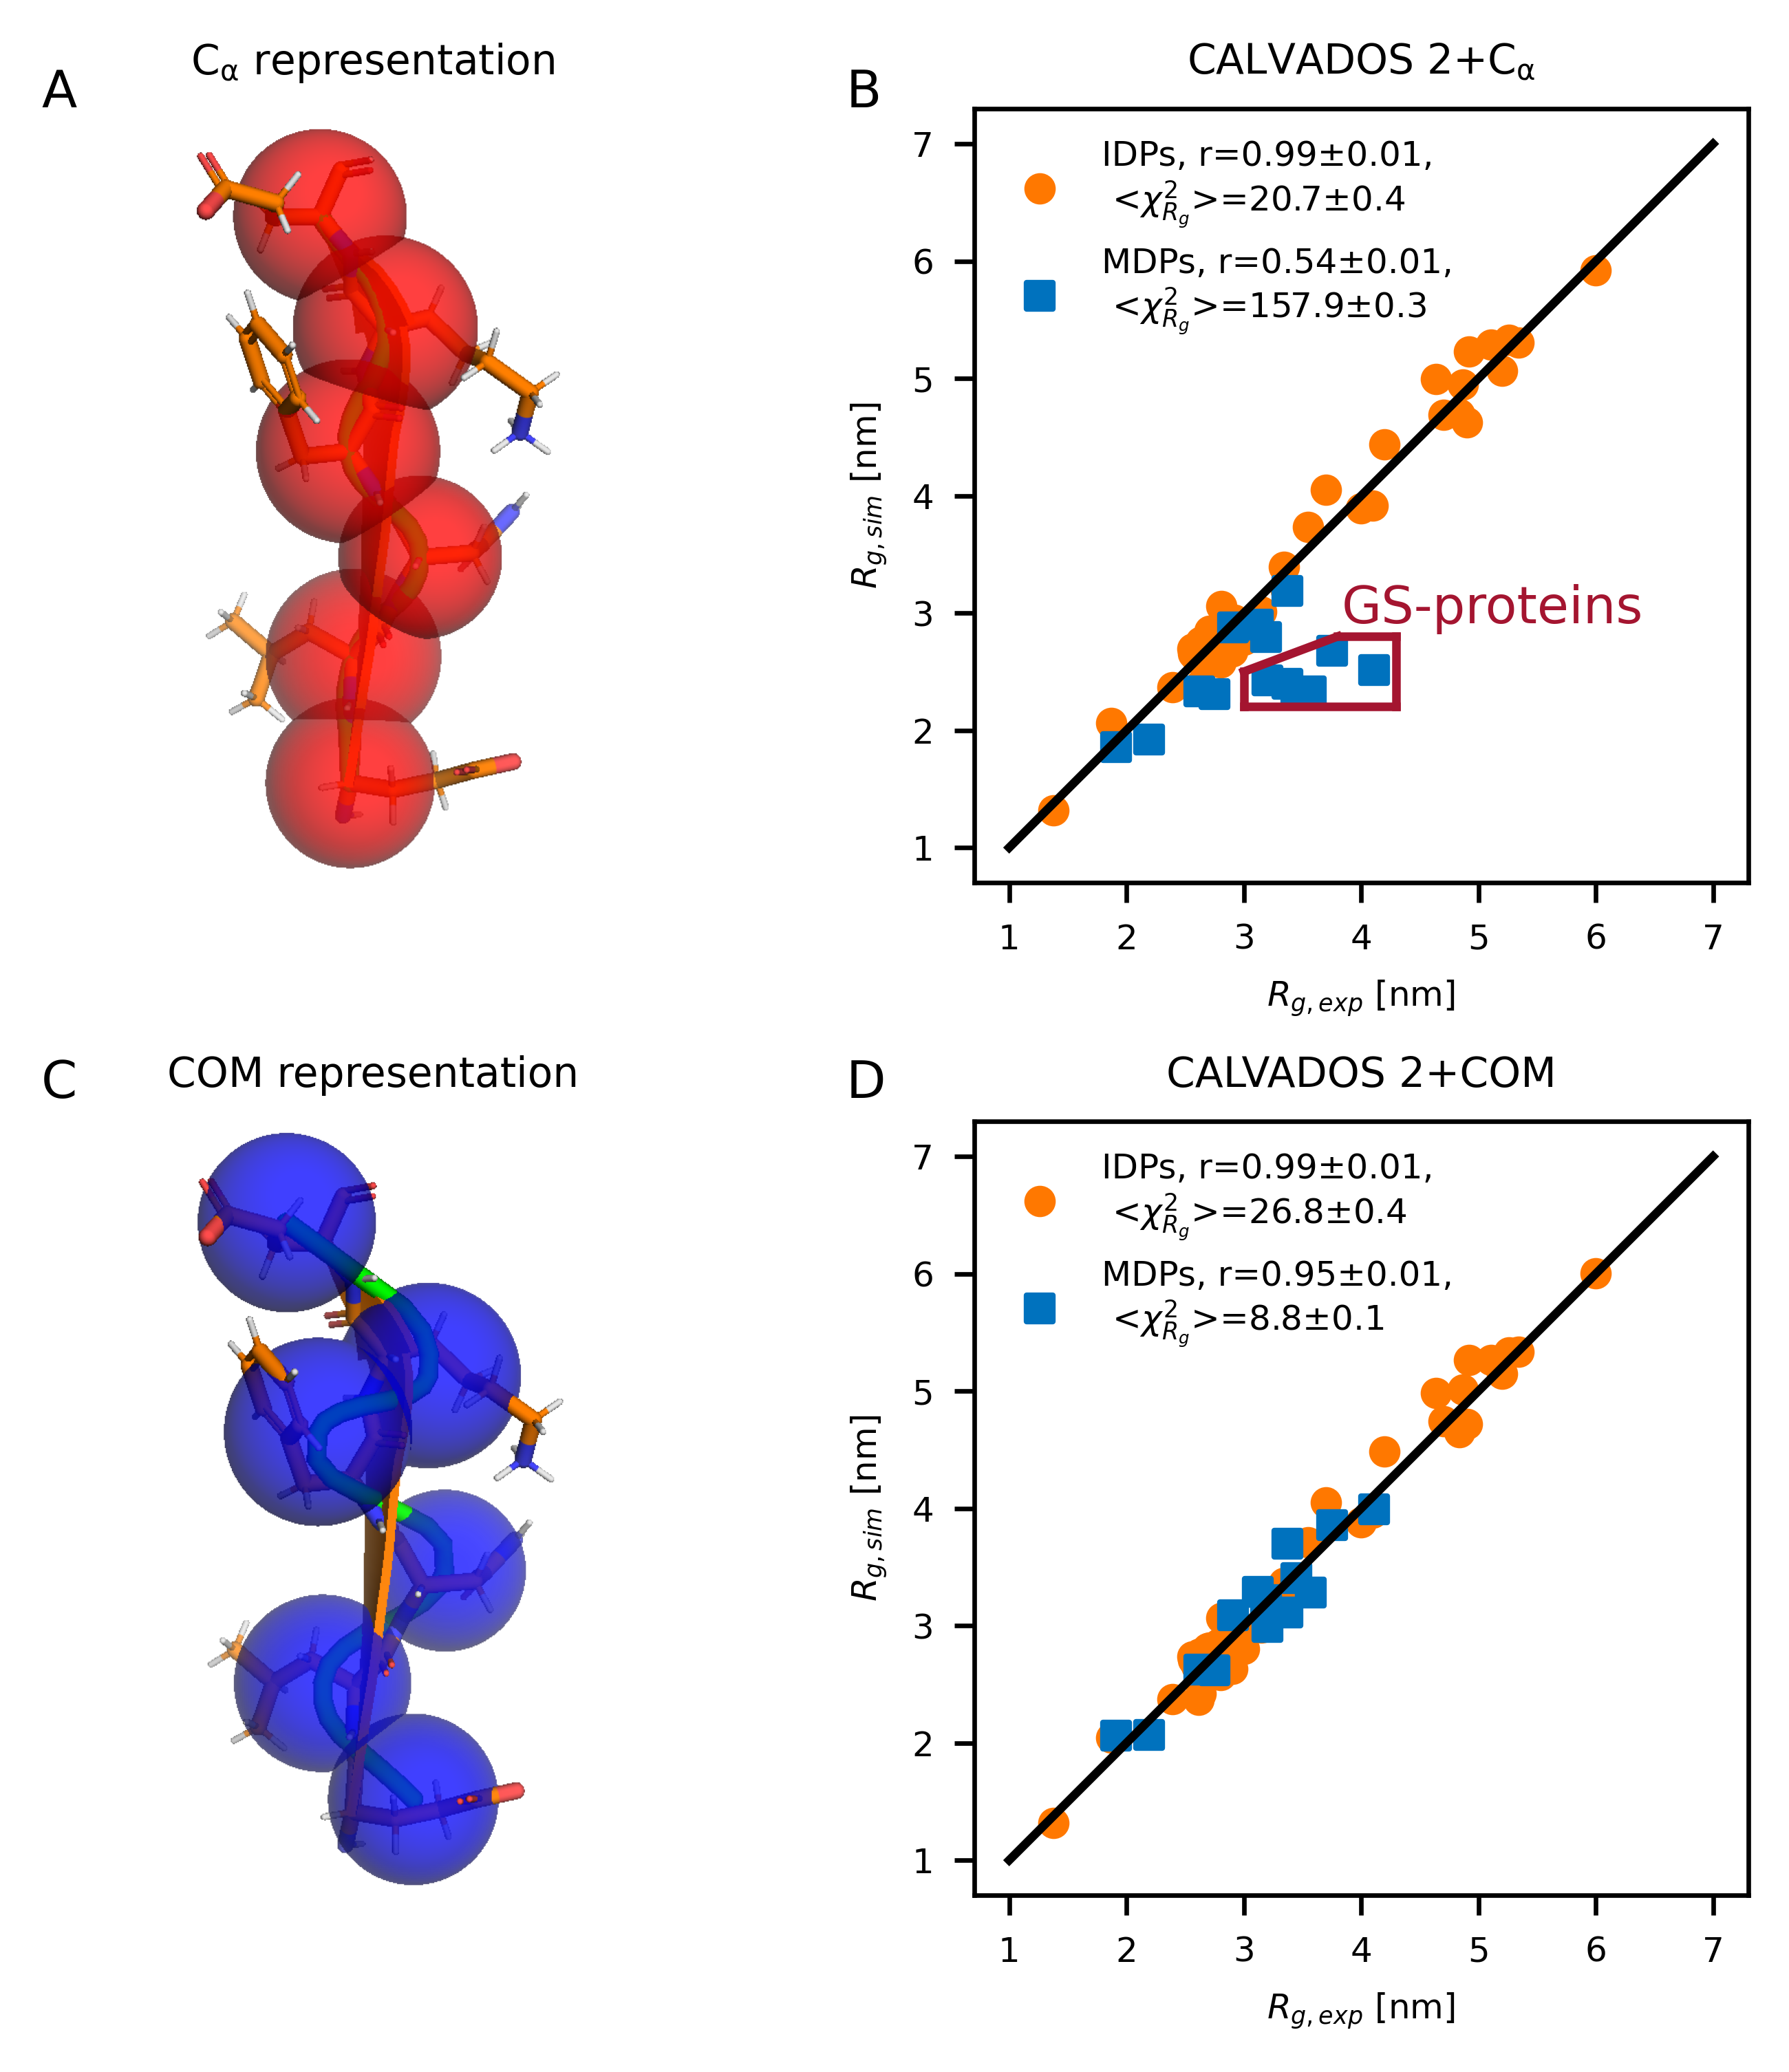

In [4]:
text_size = 6
label_size = text_size*1.5
s = 20
linewidth = 1
times = 100
string_chi2_rg = "$χ^2_{R_g}$"
mpl.rc('font', size=text_size)
def fig1_1(ax1,ax2):
    cwd = "."
    CA_png = Image.open(f'{cwd}/paper_multidomainCALVADOS/CA.png')
    COM_png = Image.open(f'{cwd}/paper_multidomainCALVADOS/COM.png')
    ax1.set_xlim(0, CA_png.width)
    ax1.set_ylim(CA_png.height, 0)
    ax1.set_title("$\\rm{C_α}$ representation")
    ax2.set_xlim(0, COM_png.width)
    ax2.set_ylim(COM_png.height, 0)
    ax2.set_title("COM representation")
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(CA_png)
    ax2.imshow(COM_png)

def fig1_2(ax_list):
    cwd = "./data"
    validate = False  # this validate is used to determine which set of proteins to use, training or validation?
    bootstrapping = True
    # use current lambda values to simulate next cycle
    label_dict = {"CALVADOS2CA_2.0_0.05_1_validate": "CALVADOS 2+$\\rm{C_α}$",
        "CALVADOS2COM_2.0_0.05_1_validate": "CALVADOS 2+COM"}
    dataset_tuples = {"CALVADOS2CA_2.0_0.05_1_validate": -1,
                     "CALVADOS2COM_2.0_0.05_1_validate": -1}
    for dataset_tuple_idx, dataset in enumerate(list(dataset_tuples.keys())):
        cycle = dataset_tuples[dataset]
        PRE_seq = list(pd.read_pickle(f"{cwd}/{dataset}/proteinsPRE.pkl").index)
        predictions, IDP_names, multidomain_names = get_predictions(cwd, dataset, cycle, validate, PRE_seq, bootstrapping=bootstrapping)

        Rg_exp = np.array(predictions.loc[IDP_names+multidomain_names]["expRg"])
        RgIDPs_exp = np.array(predictions.loc[IDP_names]["expRg"])
        RgMDPs_exp = np.array(predictions.loc[multidomain_names]["expRg"])

        Rg_cal = np.array(predictions.loc[IDP_names+multidomain_names]["cal"])
        RgIDPs_cal = np.array(predictions.loc[IDP_names]["cal"])
        RgMDPs_cal = np.array(predictions.loc[multidomain_names]["cal"])

        RgIDPs_bt = np.array([predictions.loc[name, "bt"] for name in IDP_names])  # (n_seq, times)
        RgMDPs_bt = np.array([predictions.loc[name, "bt"] for name in multidomain_names])  # (n_seq, times)
        # Error = np.array(predictions.loc[IDP_names+multidomain_names]["err"])
        RgIDPs_err = np.array(predictions.loc[IDP_names]["expRgErr"])
        RgMDPs_err = np.array(predictions.loc[multidomain_names]["expRgErr"])
        # Rg_exp_vs_Rg_calc
        chi2_Rg_IDPs = np.power((RgIDPs_exp - RgIDPs_cal) / RgIDPs_err, 2)
        print(predictions.loc[IDP_names][["expRg", "cal", "expRgErr"]])
        chi2_Rg_MDPs = np.power((RgMDPs_exp - RgMDPs_cal) / RgMDPs_err, 2)

        chi2_Rg_IDPs_res = np.power((RgIDPs_exp - RgIDPs_bt.T) / RgIDPs_err, 2).mean(axis=1)
        chi2_Rg_MDPs_res = np.power((RgMDPs_exp - RgMDPs_bt.T) / RgMDPs_err, 2).mean(axis=1)

        corrcoef_RgIDPs = np.corrcoef(RgIDPs_exp, RgIDPs_cal)[0][1]  # r
        corrcoef_RgMDPs = np.corrcoef(RgMDPs_exp, RgMDPs_cal)[0][1]

        corrcoef_RgIDPs_res = []
        corrcoef_RgMDPs_res = []
        for time in range(RgIDPs_bt.shape[-1]):
            corrcoef_RgIDPs_res.append(np.corrcoef(RgIDPs_exp, RgIDPs_bt.T[time])[0][1])
            corrcoef_RgMDPs_res.append(np.corrcoef(RgMDPs_exp, RgMDPs_bt.T[time])[0][1])
        string_chi2_rg = "$χ^2_{R_g}$"

        ax_list[dataset_tuple_idx].scatter(RgIDPs_exp, RgIDPs_cal, label=f"IDPs, r={np.round(corrcoef_RgIDPs, 2)}\u00B1{0.01 if np.round(np.std(corrcoef_RgIDPs_res), 2) < 0.001 else np.round(np.std(corrcoef_RgIDPs_res), 2)},\n <{string_chi2_rg}>={np.round(chi2_Rg_IDPs.mean(), 1)}\u00B1{np.round(chi2_Rg_IDPs_res.std(), 1)}", color=orange, s=s, marker="o")
        ax_list[dataset_tuple_idx].scatter(RgMDPs_exp, RgMDPs_cal, label=f"MDPs, r={np.round(corrcoef_RgMDPs, 2)}\u00B1{0.01 if np.round(np.std(corrcoef_RgMDPs_res), 2) < 0.001 else np.round(np.std(corrcoef_RgMDPs_res), 2)},\n <{string_chi2_rg}>={np.round(chi2_Rg_MDPs.mean(), 1)}\u00B1{np.round(chi2_Rg_MDPs_res.std(), 1)}", color=blue, s=s, marker="s")
        coefficient = np.corrcoef(Rg_exp, Rg_cal)[0][1]
        # assert len(allproteins.index) == len(Rg_cal)
        ax_list[dataset_tuple_idx].plot([1, 7], [1, 7], color="black")
        ax_list[dataset_tuple_idx].set_ylabel("$R_{g,sim}$ [nm]")
        ax_list[dataset_tuple_idx].set_xlabel("$R_{g,exp}$ [nm]")
        ax_list[dataset_tuple_idx].set_aspect('equal')
        ax_list[dataset_tuple_idx].tick_params(axis='x')
        ax_list[dataset_tuple_idx].tick_params(axis='y')
        ax_list[dataset_tuple_idx].set_title(label_dict[dataset])
        ax_list[dataset_tuple_idx].legend(edgecolor="white", frameon=False)
        if dataset_tuple_idx==0:
            ax_list[dataset_tuple_idx].plot((3, 4.3), (2.2, 2.2), color=red)
            ax_list[dataset_tuple_idx].plot((3, 3), (2.2, 2.5), color=red)
            ax_list[dataset_tuple_idx].plot((4.3, 4.3), (2.2, 2.8), color=red)
            ax_list[dataset_tuple_idx].plot((3.8, 4.3), (2.8, 2.8), color=red)
            ax_list[dataset_tuple_idx].plot((3, 3.8), (2.5, 2.8), color=red)
cwd = "./data"
fig = plt.figure(figsize=(5,5), dpi=600)
ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((2,2), (1,1), rowspan=1, colspan=1)


fig1_1(ax1, ax3)
fig1_2([ax2, ax4])


plt.tight_layout()

fig.text(0.1, 0.95, 'A', fontsize=label_size)
fig.text(0.49, 0.95, 'B', fontsize=label_size)
fig.text(0.1, 0.47, 'C', fontsize=label_size)
fig.text(0.49, 0.47, 'D', fontsize=label_size)
fig.text(0.73, 0.7, 'GS-proteins', fontsize=label_size, color=red)


plt.show()
fig.savefig('./paper_multidomainCALVADOS/fig1.pdf', bbox_inches='tight')

In [2]:
%pwd

'/lindorffgrp-isilon/fancao/_2024_Cao_CALVADOSCOM'